# Distance calculate


Import libraries

In [186]:
import numpy as np
import cv2
from PIL import Image 
from ultralytics import YOLO
import cv2
import math
import geocoder
import folium
import matplotlib.pyplot as plt

Open output.txt file to extract the paremeters calibrated by Camera_calibration.py

In [187]:
with open(r'D:\python\Distance_measurement\output.txt', 'r') as f:
    fx = float(f.readline().strip())
    fy = float(f.readline().strip())
    cx = float(f.readline().strip())
    ppx = float(f.readline().strip())
    ppy = float(f.readline().strip())
    cy = float(f.readline().strip())
print("fx = {},\nfy = {},\ncx = {},\nppx = {},\nppy = {},\ncy = {}".format(fx, fy, cx, ppx, ppy, cy))


fx = 2440.9540138328043,
fy = 2434.6728574963054,
cx = 1944.0,
ppx = 1248.1362594555521,
ppy = 957.0167856547552,
cy = 2592.0


Calculate focal length

In [188]:
mtx = np.array([[fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]])
# focal length
f = (fx + fy) / 2
display(mtx)
print("focal length = ", f)

array([[       2441,           0,        1944],
       [          0,      2434.7,        2592],
       [          0,           0,           1]])

focal length =  2437.813435664555


##### Applying YOLOv8

Defiine model and example image

In [189]:
model = YOLO("yolov8n.pt")
img = cv2.imread(r'D:\python\Distance_measurement\test10.jpg')


Extract xmin, xmax, ymin, ymax

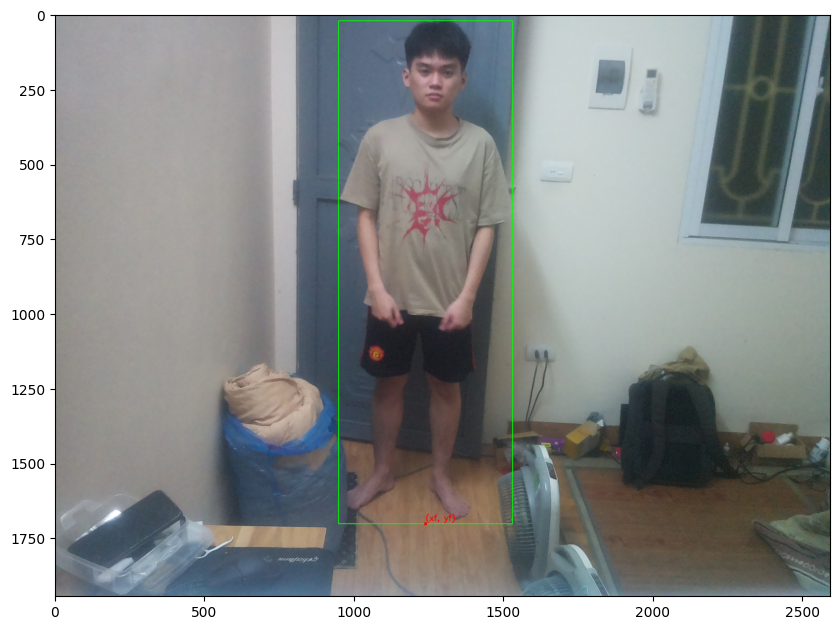

xmin = 948,
ymin = 22,
xmax = 1530,
ymax = 1702


In [190]:
CONFIDENCE_THRESHOLD = 0.8
GREEN = (0, 255, 0)

detections = model(img, verbose=False)[0]
for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]

        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # draw the bounding box on the frame
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        cv2.rectangle(img, (xmin, ymin) , (xmax, ymax), GREEN, 2)
xf = int(0.5 * (xmin + xmax))
yf = int(ymax)
cv2.circle(img, (xf, yf), radius=5, color=(0, 0, 255), thickness=-1)
cv2.putText(img, "(xf, yf)", (xf, yf - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("xmin = {},\nymin = {},\nxmax = {},\nymax = {}".format(xmin, ymin, xmax, ymax))

##### Object depth estimation

In [191]:
# Extrinsic parameters (tham số ngoại bao gồm vị trí và hướng camera)
# Camera position
UAV_lat = 21.0016548
UAV_lon = 105.8516728

# Compass dỉection
p = 339

# Camera height
H = 0.008

# Camera angle
alpha = 75

In [192]:
xn = (xf - cx) / fx
yn = (yf - cy) / fy
display(xn, yn)

-0.2888215001203582

-0.3655521920572241

P: primary point in 2D image<br>
F: Human foot point in 2D image<br>
F: corresponding point of P in 3D<br>
F': corresponding Human foot point in 3D<br>

In [193]:
Zp      = H * (1 / math.cos(alpha))     # Zp = OP'
display(Zp)

0.008679130978999288

In [194]:
P = (cx / 2, cy / 2)
B = (0, P[1])
A = (P[0], 0)
O = (P[0], P[1], H)
BP = math.sqrt((P[0] - B[0])**2 + (P[1] - B[1])**2)
AP = math.sqrt((P[0] - A[0])**2 + (P[1] - A[1])**2)
OP = f
F = (xf, yf)
tan_BOP = BP / OP
tan_AOP = AP / OP
display(BP, AP, OP)


972.0

1296.0

2437.813435664555

In [195]:
dx = 1000 * f * tan_BOP
dy = 1000 * f * tan_AOP
sx = cx / dx
sy = cy / dy

d = math.sqrt(((cx - xf)/sx)**2 + ((cy -yf)/sy)**2)
teta = math.atan(d / f)
Z = Zp * (1/math.cos(teta))
xc = xn * Z
yc = yn * Z
zc = Z  

Compass direction: p (input)<br>
Current location: (input)<br>

In [196]:
xb = xc
yb = yc*math.cos(alpha)
zb = -yc*math.sin(alpha) + zc*math.cos(alpha)

E = zb*math.sin(math.radians(p)) + xb*math.cos(math.radians(p))
N = zb*math.cos(math.radians(p)) - xb*math.sin(math.radians(p))
U = -yb

display(E, N, U)

1.438760119846727

-0.8695065706602805

0.6810208951208059

In [197]:
b = math.atan(abs(E / N))
s = math.sqrt(E**2 + N**2)
dX = s*math.sin(b)
dY = s*math.cos(b)

In [198]:
delta_lo = dX / (11320 * math.cos(math.radians(UAV_lon)))
delta_la = dY / 110540

In [199]:
laf = UAV_lat + delta_la
lof = UAV_lon + delta_lo
display(laf, lof)

21.001662665990327

105.8512074882037

In [200]:
m = folium.Map(location=[UAV_lat, UAV_lon], zoom_start=15)
folium.Marker(location=[UAV_lat, UAV_lon], popup='UAV').add_to(m)
folium.Marker(location=[laf, lof], popup='Target', icon=folium.Icon(color="red")).add_to(m)
m    